# Data Loading
> *If you cannot see the HTML rendering (e.g. colors), view this notebook [here](https://nbviewer.jupyter.org/github/Mipanox/Bird_cocktail/blob/master/notebooks/data_loading.ipynb)*

*(Dated: 03/03/18; following data preprocessing [notebook](https://github.com/Mipanox/Bird_cocktail/blob/master/notebooks/data_preprocessing.ipynb))*

In this notebook, the options of loading data in the `model/` folder are explained. In particular, data augmentation and mixing with multiple species as well as noise are done in the step of loading data.

The task requires familiarity of the `Dataloader` and `ImageFolder` classes in `torchvision`. See the official [tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html) and [documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder).
<br><br>
<font color="blue">**Note:** This notebook is for demonstration purposes only. The dataloaders are called when training/evaluating the model. See [README](https://github.com/Mipanox/Bird_cocktail)</font>

In [7]:
import sys
sys.path.append('../codes/')
from other_util import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
% matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

## 0. Introduction
We have two ways of sampling the data: 
1. **Single-species with noise**: If the model trains from spectrograms of individual species (separately), the data is loaded by random sampling the images (spectrograms) and randomly superposing with noise, also obtained from [pre-processing](https://github.com/Mipanox/Bird_cocktail#data-pre-processing)

2. **Multi-species with noise**: For training on mixture of sounds, the loader first randomly chooses 1~N spectrograms <font color="grey">(with N specifiable; if all species have same number of spectrograms, this is essentially "how many species appear together in an audio clip")</font>, and then superpose them with random weights <font color="grey">(linear in intensity)</font>, as well as noise, in the same manner described above in 1.


**Note:** In any step of randomly selecting spectrograms, we use a fixed random seed to ensure reproducibility

## 1. Noises
As explained in [pre-processing](https://github.com/Mipanox/Bird_cocktail#data-pre-processing), we have isolated some segments of sounds without significant signal, which we use to augment our data, by randomly adding one of them to the current indexed spectrogram. An example noise spectrogram looks like this:

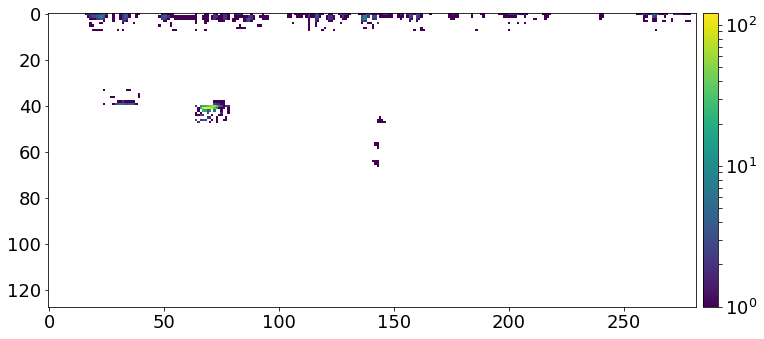

In [11]:
noise = Image.open('../datasets/Xeno-Canto/spec_test/noise/NorthernSaw-whetOwl/8.0_NorthernSaw-whetOwl002_24.jpg')
plt.figure(figsize=(12,7))
im = plt.imshow(np.array(noise), norm=LogNorm()); add_colorbar(im)

## 2. Synthesize data
Let's first load some test spectrograms

In [52]:
exec(open('../codes/other_util.py'))

In [53]:
## single-species: 2.1
sing_dset = BirdFolder(root='../datasets/Xeno-Canto/split_test/train/', \
                       noise_root='../datasets/Xeno-Canto/spec_test/noise/',transform=train_transformer,
                       aug_factor=1,mixing=False)
## multi-species: 2.2
mult_dset = BirdFolder(root='../datasets/Xeno-Canto/split_test/train/', \
                       noise_root='../datasets/Xeno-Canto/spec_test/noise/',transform=train_transformer,
                       aug_factor=2,mixing=True)

### 2-1. Single-species
Rather simple here. Just add the randomly chosen noise to the spectrogram at this index, from the dataloader. If we call spectrogram # 1248:

Total number of data: 32388
 chosen noise to be added to signal: 7.0_Bewick%27sWren103_56.jpg


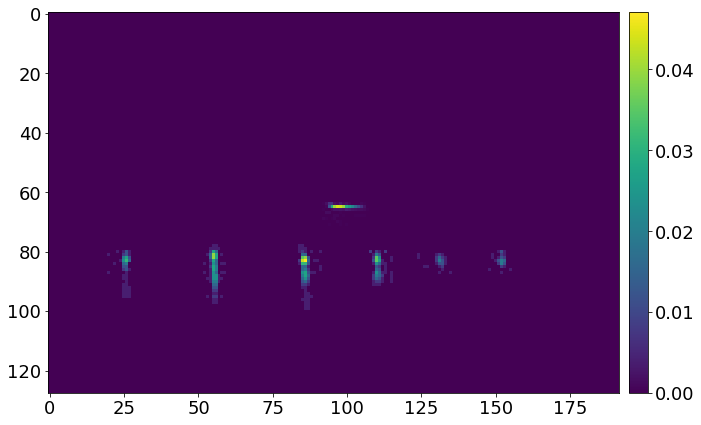

In [57]:
img, tar = sing_dset[1248]
plt.figure(figsize=(12,7))
im = plt.imshow((np.array(img[0])*255)); add_colorbar(im)

This particular spectrogram is thus synthesized from the noise: `0.0_Bewick%27sWren207_193.jpg` and the target:

In [47]:
tar_ar = np.array(tar)
print sing_dset.classes[np.where(tar_ar==1.)[0][0]]

Bewick%27sWren


### 2-2. Multi-species
In addition to the random noise, we also [require](#0.-Introduction) the following to be random:
- **How many species / Which spectrograms to synthesize**: here 1 -- 5
- **Relative weights of the synthesized spectrograms**: 0 -- 1 in intensity

Furthermore, the user can specify how many more data they want. This is given in the `aug_factor` argument. In this example, where we use `aug_factor=2`, we will have twice as many data samples as the 2.1 case

Total number of data: 64776
 chosen noise to be added to signal: 0.0_FoxSparrow074_92.jpg
 5 spectrograms are drawn with strengths [0.74547148 0.57231354 0.45824118 0.3847059  0.27398931]
 and they are from species: [0, 0, 3, 1, 1]


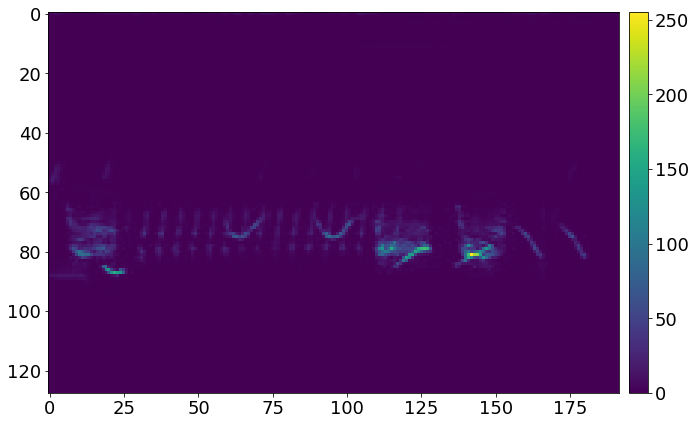

In [60]:
img, tar = mult_dset[124]
plt.figure(figsize=(12,7))
im = plt.imshow((np.array(img[0])*255)); add_colorbar(im)

In this particular example, we see that the synthesized spectrogram comes from five individual bird sounds, with two species #0 <font color="grey">(Bewick's Wren)</font> and two species #1 <font color="grey">(Fox Sparrow)</font> :

In [65]:
tar_ar = np.array(tar)
for t in np.where(tar_ar==1.)[0]:
    print sing_dset.classes[t]

Bewick%27sWren
FoxSparrow
RedCrossbill


## Summary
So, if you wish to train the model with single/multi-species spectrograms, simply specify that to the `fetch_dataloader` function when training the model. For instance, you may wish to include more species to synthesize, and/or want more data samples by increasing `aug_factor`, etc.